## Setup

In [1]:
import pandas as pd
from prophet import Prophet

In [2]:
man_df = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv')
man_df.head()

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


# Meta's Prophet

Prophet follows the `sklearn` model API. We create an instance of the `Prophet` class and then call its `fit` and `predict` methods. 

The input to Prophet is always a dataframe with two columns: `ds` and `y`. The `ds` (datestamp) column should be of a format expected by Pandas, ideally `YYYY-MM-DD` for a date or `YYYY-MM-DD HH:MM:SS` for a timestamp. The `y` column _must_ be numeric, and represents the measurement we wish to forecast. Additional regressors may be added with the `add_regressor()` model method (see below).

# Quickstart Example

Forecasting daily page views for a random page (Peyton Manning).

In [3]:
man_df.head()

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


In [25]:
# Fitting Prophet model
from prophet import Prophet
m = Prophet()
m.fit(man_df)

23:13:35 - cmdstanpy - INFO - Chain [1] start processing
23:13:35 - cmdstanpy - INFO - Chain [1] done processing


## Creating Future Data

You can get a dataframe that extends into the future a specified number of days using the helper method `Prophet.make_future_dataframe`. By default it will also include the dates from the history

In [11]:
future = m.make_future_dataframe(periods=5*365)
future.tail()

,ds
4725,2021-01-14
4726,2021-01-15
4727,2021-01-16
4728,2021-01-17
4729,2021-01-18


The predict method will assign each row in future a predicted value which it names `yhat`. If you pass in historical dates, it will provide an _in-sample fit_. The forecast object here is a new dataframe that includes a column `yhat` with the forecast, as well as columns for components and uncertainty intervals.

In [27]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
4725,2021-01-14,6.556441,2.278713,11.259489
4726,2021-01-15,6.580930,2.110437,11.223476
4727,2021-01-16,6.359785,2.050365,11.154732
4728,2021-01-17,6.739839,2.301419,11.463209
4729,2021-01-18,7.062744,2.608634,11.836714


You can plot the forecast by calling the `Prophet.plot` method and passing in your forecast dataframe.

/Users/kirkwood.donavin/Documents/PROPHET/.venv/lib/python3.12/site-packages/prophet/plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/Users/kirkwood.donavin/Documents/PROPHET/.venv/lib/python3.12/site-packages/prophet/plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



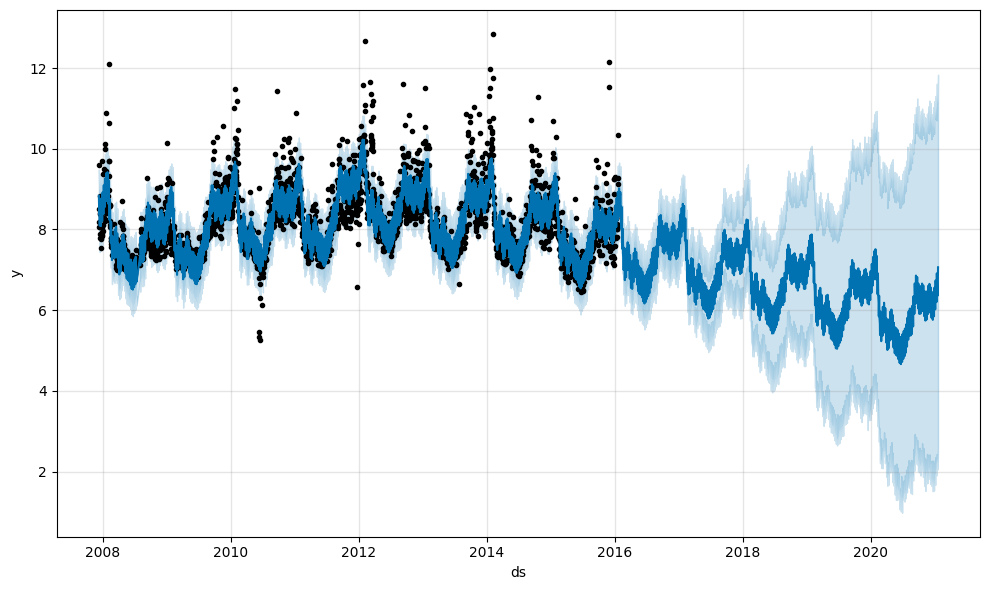

In [28]:
fig1 = m.plot(forecast)

If you want to see the forecast components, you can use the `Prophet.plot_components` method. By default you’ll see the trend, yearly seasonality, and weekly seasonality of the time series. If you include holidays, you’ll see those here, too.

/Users/kirkwood.donavin/Documents/PROPHET/.venv/lib/python3.12/site-packages/prophet/plot.py:228: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/Users/kirkwood.donavin/Documents/PROPHET/.venv/lib/python3.12/site-packages/prophet/plot.py:351: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/Users/kirkwood.donavin/Documents/PROPHET/.venv/lib/python3.12/site-packages/prophet/plot.py:354: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np

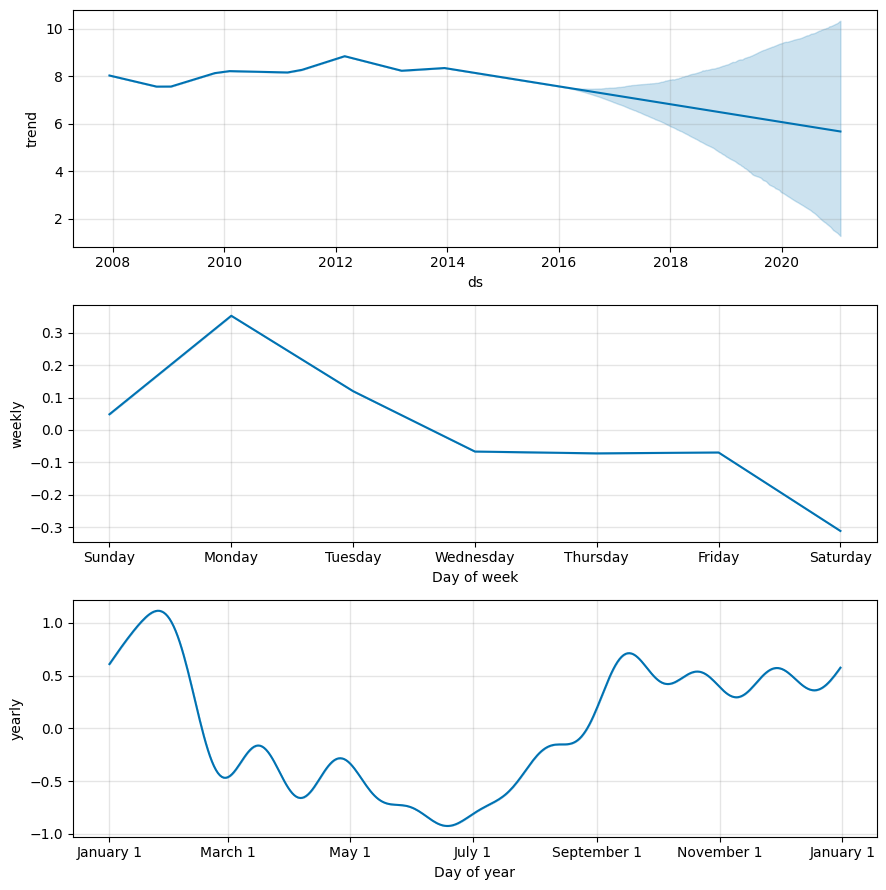

In [29]:
fig2 = m.plot_components(forecast)

In [30]:
#Interactive Plotly graph -- non functional
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

# Saturating Forecast

By default, Prophet uses a linear model for its forecast. When forecasting growth, there is usually some maximum achievable point: total market size, total population size, etc. This is called the _carrying capacity_, and the forecast should saturate at this point. Prophet allows you to make forecasts using a _logistic growth trend model_, with a specified carrying `cap`.

In [31]:
#Number of page visits to the R (programming language) Wiki page: https://en.wikipedia.org/wiki/R_%28programming_language%29
R_wiki_df = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv')
R_wiki_df['cap'] = 8.5

We must specify the carrying capacity in a column cap. Here a particular value is assumed, but this would usually be set using data or expertise about the market size. Note that `cap` does _not_ need to be a constant. And, note that this capacity must be set for future DataFrames as well.

23:13:36 - cmdstanpy - INFO - Chain [1] start processing
23:13:37 - cmdstanpy - INFO - Chain [1] done processing
/Users/kirkwood.donavin/Documents/PROPHET/.venv/lib/python3.12/site-packages/prophet/plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/Users/kirkwood.donavin/Documents/PROPHET/.venv/lib/python3.12/site-packages/prophet/plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



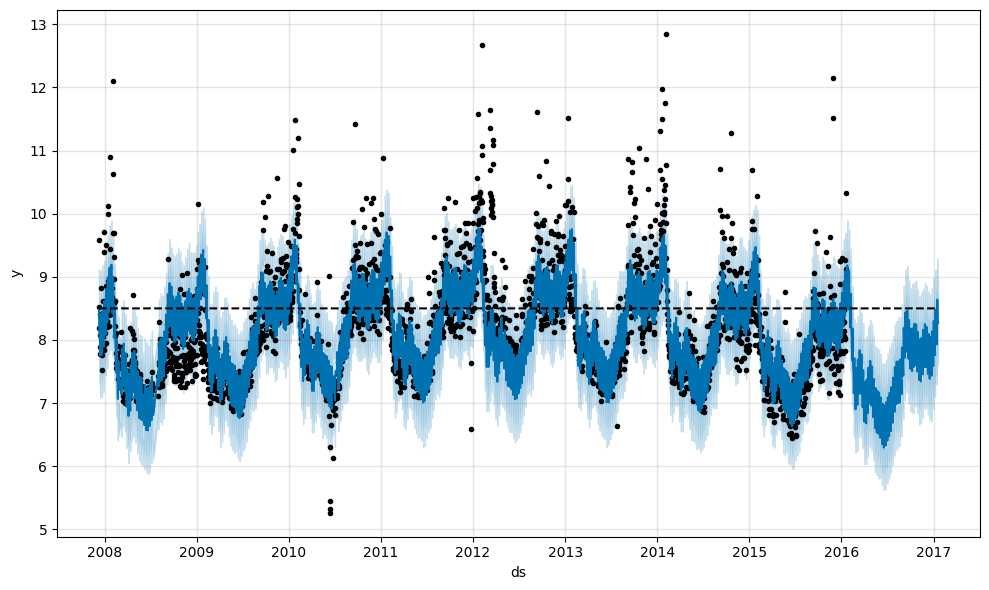

In [32]:
#Fitting the model
m = Prophet(growth='logistic')
m.fit(R_wiki_df)

#Future-casting
future = m.make_future_dataframe(periods=1*365)
future['cap'] = 8.5
fcst = m.predict(future)
fig = m.plot(fcst)

Note the dotted line to incicate the carrying capacity. The logistic growth model can also handle a saturating minimum with a column `floor`.

23:13:39 - cmdstanpy - INFO - Chain [1] start processing
23:13:39 - cmdstanpy - INFO - Chain [1] done processing
/Users/kirkwood.donavin/Documents/PROPHET/.venv/lib/python3.12/site-packages/prophet/plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/Users/kirkwood.donavin/Documents/PROPHET/.venv/lib/python3.12/site-packages/prophet/plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



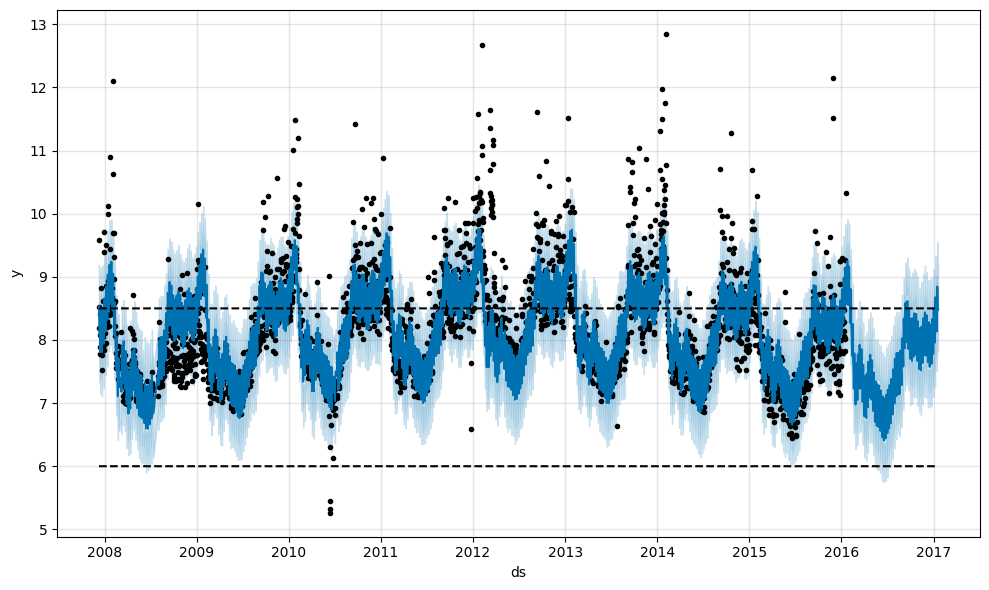

In [33]:
R_wiki_df['floor'] = 6
future['floor'] = 6
m = Prophet(growth='logistic')
m.fit(R_wiki_df)
fcst = m.predict(future)
fig = m.plot(fcst)

# Trend Changepoints

Real time series frequently have abrupt changes in their trajectories. By default, Prophet will automatically detect these changepoints and will allow the trend to adapt appropriately. Prophet detects changepoints by first specifying a large number of potential changepoints at which the rate is allowed to change. It then puts a sparse prior on the magnitudes of the rate changes (equivalent to L1 regularization) - this essentially means that Prophet has a large number of possible places where the rate can change, but will use as few of them as possible. The locations of the signification changepoints can be visualized with:

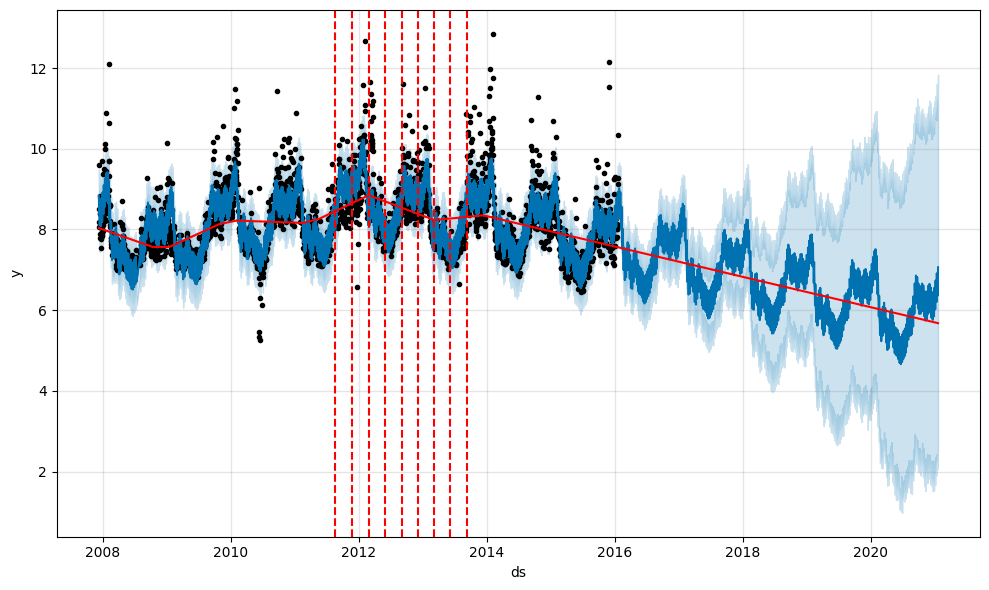

In [34]:
from prophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

By default changepoints are only inferred for the first 80% of the time series in order to have plenty of runway for projecting the trend forward and to avoid overfitting fluctuations at the end of the time series. This default works in many situations but not all, and can be changed using the `changepoint_range` argument. For example, `m = Prophet(changepoint_range=0.9)`.

However, if you wish to have finer control over this process (e.g., Prophet missed a rate change, or is overfitting rate changes in the history), then there are several input arguments you can use. The number of potential changepoints can be set using the argument `n_changepoints`, but this is better tuned by adjusting the regularization.

## Manual Selection

If you wish, rather than using automatic changepoint detection you can manually specify the locations of potential changepoints with the `changepoints` argument. Slope changes will then be allowed only at these points, with the same sparse regularization as before. One could, for instance, create a grid of points as is done automatically, but then augment that grid with some specific dates that are known to be likely to have changes. As another example, the changepoints could be entirely limited to a small set of dates, as is done here:

In [ ]:
m = Prophet(changepoints=['2014-01-01'])
forecast = m.fit(man_df).predict(future)
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

## Trend Flexibility

If the trend changes are being overfit (too much flexibility) or underfit (not enough flexibility), you can adjust the strength of the sparse prior using the input argument `changepoint_prior_scale`. By default, this parameter is set to 0.05. Increasing it will make the trend more flexible. Or, decreasing it will make the model less flexible (i.e., under-fit).

23:13:41 - cmdstanpy - INFO - Chain [1] start processing
23:13:42 - cmdstanpy - INFO - Chain [1] done processing
/Users/kirkwood.donavin/Documents/PROPHET/.venv/lib/python3.12/site-packages/prophet/plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/Users/kirkwood.donavin/Documents/PROPHET/.venv/lib/python3.12/site-packages/prophet/plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



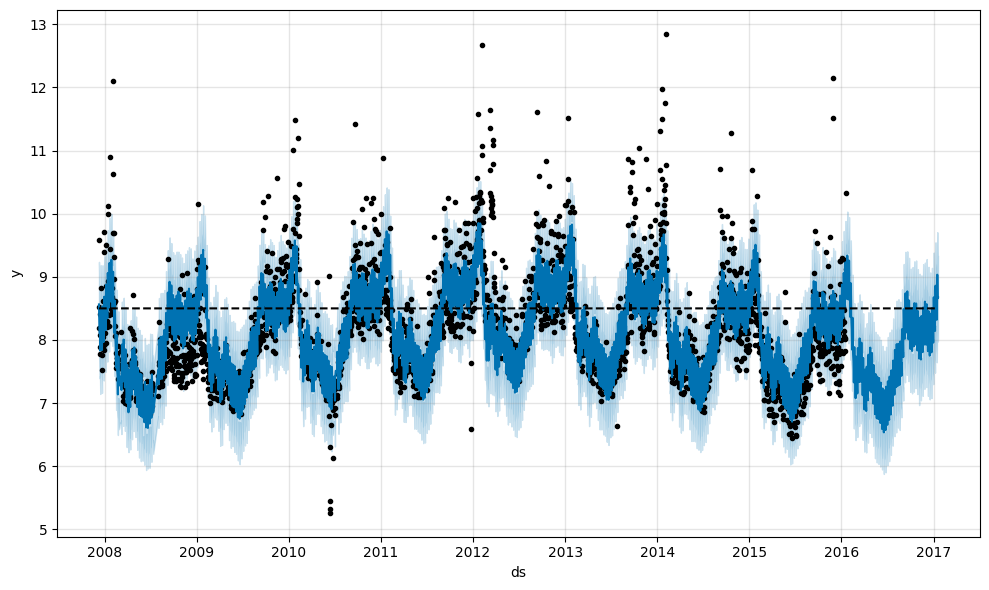

In [36]:
m = Prophet(changepoint_prior_scale=0.001)
forecast = m.fit(man_df).predict(future)
fig = m.plot(forecast)

When visualizing the forecast, this parameter can be adjusted as needed if the trend seems to be over- or under-fit. In the fully-automated setting, see the section on cross-validation for recommendations on how this parameter can be tuned.

# Holiday Effects

## Modeling Special Events

If you have holidays or other recurring events that you’d like to model, you must create a dataframe for them. It must have two columns (`holiday` and `ds`) and a row for each occurrence of the holiday. It must include all occurrences of the holiday, both in the past (back as far as the historical data go) and in the future (out as far as the forecast is being made). If they won’t repeat in the future, Prophet will model them and then not include them in the forecast.

You can also include columns lower_window and upper_window which extend the holiday out to `[lower_window, upper_window]` days around the date. For instance, if you wanted to include Christmas Eve in addition to Christmas you’d include `lower_window=-1, upper_window=0`. If you wanted to use Black Friday in addition to Thanksgiving, you’d include `lower_window=0, upper_window=1`. 

In [37]:
playoffs = pd.DataFrame({
  'holiday': 'playoff',
  'ds': pd.to_datetime(['2008-01-13', '2009-01-03', '2010-01-16',
                        '2010-01-24', '2010-02-07', '2011-01-08',
                        '2013-01-12', '2014-01-12', '2014-01-19',
                        '2014-02-02', '2015-01-11', '2016-01-17',
                        '2016-01-24', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2010-02-07', '2014-02-02', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
holidays = pd.concat((playoffs, superbowls))
holidays

,holiday,ds,lower_window,upper_window
0,playoff,2008-01-13,0,1
1,playoff,2009-01-03,0,1
2,playoff,2010-01-16,0,1
3,playoff,2010-01-24,0,1
4,playoff,2010-02-07,0,1
5,playoff,2011-01-08,0,1
6,playoff,2013-01-12,0,1
7,playoff,2014-01-12,0,1
8,playoff,2014-01-19,0,1
9,playoff,2014-02-02,0,1


Once the table is created, holiday effects are included in the forecast by passing them in with the `holidays` argument.

In [41]:
m = Prophet(holidays=holidays)
forecast = m.fit(man_df).predict(future)
#The holiday effect can be seen in the forecast dataframe:
forecast[(forecast['playoff'] + forecast['superbowl']).abs() > 0][
        ['ds', 'trend', 'playoff', 'superbowl']][-10:]

23:15:35 - cmdstanpy - INFO - Chain [1] start processing
23:15:35 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,playoff,superbowl
2190,2014-02-02,8.261622,1.226875,1.200105
2191,2014-02-03,8.260643,1.905070,1.460637
2532,2015-01-11,7.925773,1.226875,0.000000
2533,2015-01-12,7.924794,1.905070,0.000000
2901,2016-01-17,7.562477,1.226875,0.000000
2902,2016-01-18,7.561497,1.905070,0.000000
2908,2016-01-24,7.555622,1.226875,0.000000
2909,2016-01-25,7.554643,1.905070,0.000000
2922,2016-02-07,7.541913,1.226875,1.200105
2923,2016-02-08,7.540933,1.905070,1.460637


The holiday effects will also show up in the components plot, where we see that there is a spike on the days around playoff appearances, with an especially large spike for the superbowl in the `holidays` components:

/Users/kirkwood.donavin/Documents/PROPHET/.venv/lib/python3.12/site-packages/prophet/plot.py:228: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/Users/kirkwood.donavin/Documents/PROPHET/.venv/lib/python3.12/site-packages/prophet/plot.py:351: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/Users/kirkwood.donavin/Documents/PROPHET/.venv/lib/python3.12/site-packages/prophet/plot.py:354: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np

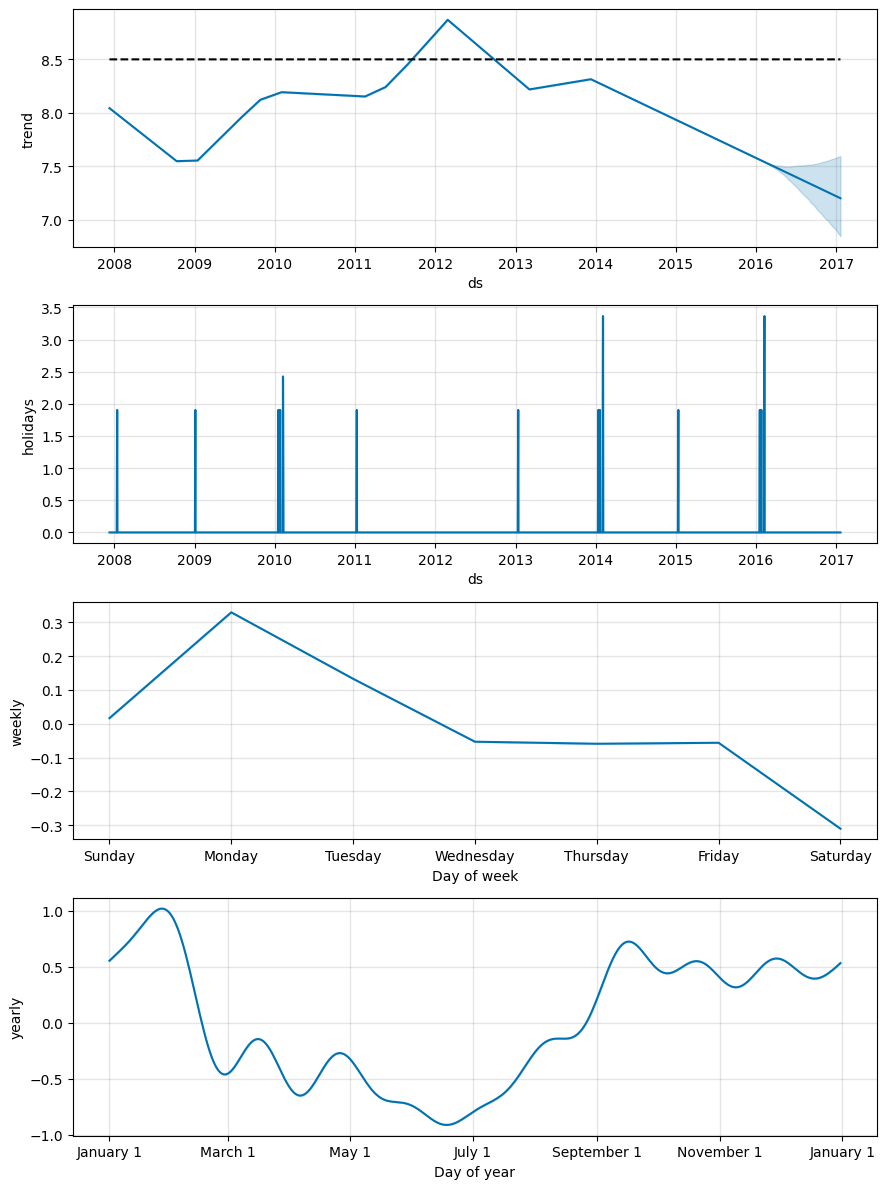

In [42]:
fig = m.plot_components(forecast)

## Built-in State Holidays

You can use a built-in collection of country-specific holidays using the `add_country_holidays` method. The name of the country is specified, and then major holidays for that country will be included in addition to any holidays that are specified via the `holidays` argument described above:

In [47]:
m = Prophet(holidays=holidays)
m.add_country_holidays(country_name='US')
m.fit(man_df)
#See included holidays with
m.train_holiday_names

23:37:13 - cmdstanpy - INFO - Chain [1] start processing
23:37:13 - cmdstanpy - INFO - Chain [1] done processing


0                         playoff
1                       superbowl
2                  New Year's Day
3                    Memorial Day
4                Independence Day
5                       Labor Day
6                    Veterans Day
7                    Thanksgiving
8                   Christmas Day
9        Christmas Day (observed)
10     Martin Luther King Jr. Day
11          Washington's Birthday
12                   Columbus Day
13        Veterans Day (observed)
14    Independence Day (observed)
15      New Year's Day (observed)
dtype: object

The holidays for each country are provided by the `holidays` package in Python. A list of available countries, and the country name to use, is available on their page: [https://github.com/vacanza/python-holidays/](https://github.com/vacanza/python-holidays/). Most holidays are computed deterministically and so are available for any date range; a warning will be raised if dates fall outside the range supported by that country.

The country holidays will also show up now on the `holidays` components

/Users/kirkwood.donavin/Documents/PROPHET/.venv/lib/python3.12/site-packages/prophet/plot.py:228: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/Users/kirkwood.donavin/Documents/PROPHET/.venv/lib/python3.12/site-packages/prophet/plot.py:351: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/Users/kirkwood.donavin/Documents/PROPHET/.venv/lib/python3.12/site-packages/prophet/plot.py:354: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np

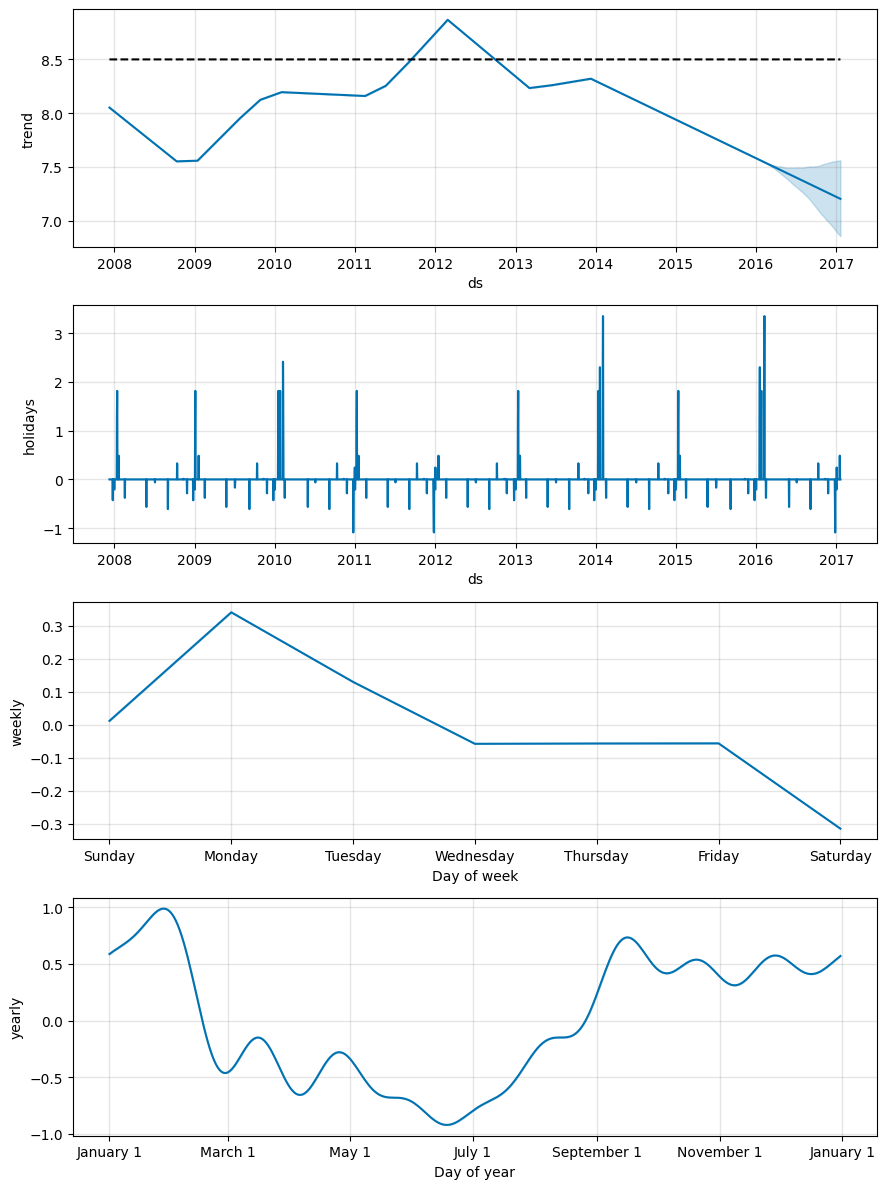

In [45]:
forecast = m.predict(future)
fig = m.plot_components(forecast)

## State & Province Holidays

Finally, state/province specific holidays that are available in the `holidays` library may be incorporated into a Prophet model with the utility function `make_holidays_df`

In [56]:
from prophet.make_holidays import make_holidays_df

ut_holidays = make_holidays_df(
    year_list=[2019 + i for i in range(10)], country='US', province='UT'
)
ut_holidays.holiday.unique()

array(["New Year's Day", 'Memorial Day', 'Independence Day', 'Labor Day',
       'Veterans Day', 'Thanksgiving', 'Christmas Day',
       'Martin Luther King Jr. Day', "Washington's Birthday",
       'Columbus Day', 'Pioneer Day', 'Independence Day (observed)',
       "New Year's Day (observed)",
       'Juneteenth National Independence Day',
       'Juneteenth National Independence Day (observed)',
       'Christmas Day (observed)', 'Pioneer Day (observed)',
       'Veterans Day (observed)'], dtype=object)

# Seasonalities

By default, Prophet fits weekly & yearly sesaonalities as long as the corresponding cycles are at least 2 in length. And, if the data period is less than daily (i.e., hourly, by-the-minute) Prophet will also estimate daily seasonalities.

## Fourier Orders

Seasonalities are estimated using a partial Fourier sum. Partial Fourier sums can approximate arbitrary periodic signals. The number of terms in the partial sum (the _order_) is a parameter that determines how quickly the seasonality can change.

The default Fourier order for yearly seasonality is 10, which produces this fit:

01:00:32 - cmdstanpy - INFO - Chain [1] start processing
01:00:33 - cmdstanpy - INFO - Chain [1] done processing
/Users/kirkwood.donavin/Documents/META_PROPHET_GUIDE/.venv/lib/python3.12/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/Users/kirkwood.donavin/Documents/META_PROPHET_GUIDE/.venv/lib/python3.12/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name + '_lower'],


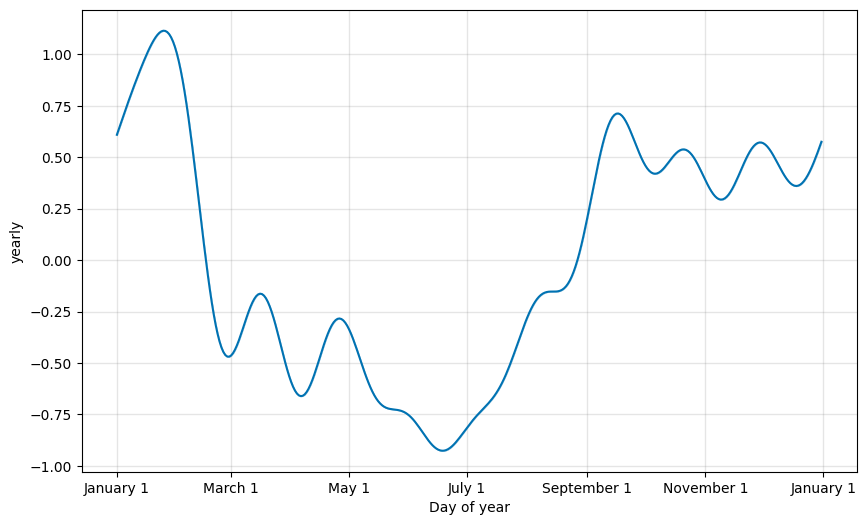

In [5]:
from prophet.plot import plot_yearly
m = Prophet().fit(man_df)
a = plot_yearly(m)

The default values are often appropriate, but they can be increased when the seasonality needs to fit higher-frequency changes, and generally be less smooth. The Fourier order can be specified for each built-in seasonality when instantiating the model, here `yearly_seasonality` is increased to 20.

01:03:03 - cmdstanpy - INFO - Chain [1] start processing
01:03:03 - cmdstanpy - INFO - Chain [1] done processing
/Users/kirkwood.donavin/Documents/META_PROPHET_GUIDE/.venv/lib/python3.12/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/Users/kirkwood.donavin/Documents/META_PROPHET_GUIDE/.venv/lib/python3.12/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name + '_lower'],


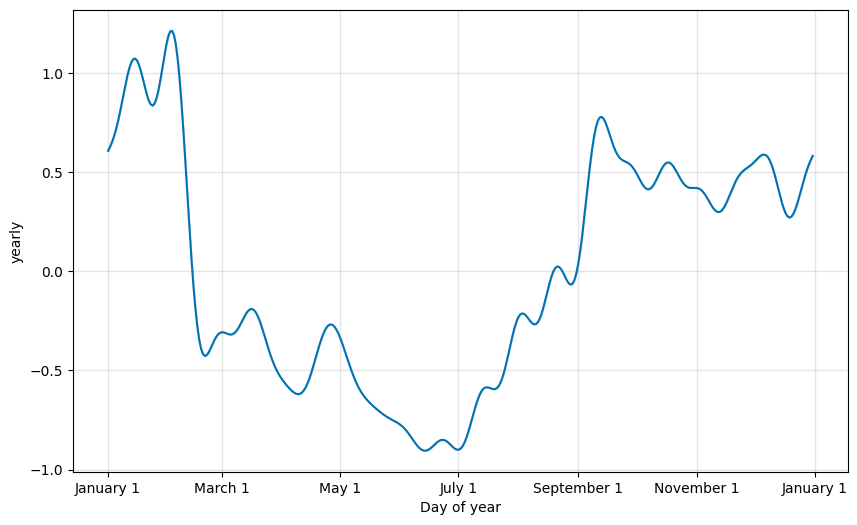

In [7]:
from prophet.plot import plot_yearly
m = Prophet(yearly_seasonality=20).fit(man_df)
a = plot_yearly(m)

Increasing the number of Fourier terms allows the seasonality to fit faster changing cycles, but can also lead to overfitting: N Fourier terms corresponds to 2N variables used for modeling the cycle. 

Prophet will by default fit weekly and yearly seasonalities (as long as those cycles are at least 2 cycles long). Also by default, Prophet uses a Fourier order of 3 for weekly seasonality and 10 for yearly seasonality. It will also fit daily seasonality for a sub-daily time series. 

## Custom Seasonality

Prophet will by default fit weekly and yearly seasonalities, if the time series is more than two cycles long. It will also fit daily seasonality for a sub-daily time series. You can add other seasonalities (monthly, quarterly, hourly) using the `add_seasonality` method.

The inputs to this function are a name, the period of the seasonality in days, and the Fourier order for the seasonality. For reference, by default Prophet uses a Fourier order of 3 for weekly seasonality and 10 for yearly seasonality.

As an example, here we fit the Peyton Manning data, but replace the `weekly_seasonality` with `'monthly'` seasonality. The monthly seasonality then will appear in the components plot:

15:47:22 - cmdstanpy - INFO - Chain [1] start processing
15:47:22 - cmdstanpy - INFO - Chain [1] done processing
/Users/kirkwood.donavin/Documents/META_PROPHET_GUIDE/.venv/lib/python3.12/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/kirkwood.donavin/Documents/META_PROPHET_GUIDE/.venv/lib/python3.12/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/Users/kirkwood.donavin/Documents/META_PROPHET_GUIDE/.venv/lib/python3.12/site-p

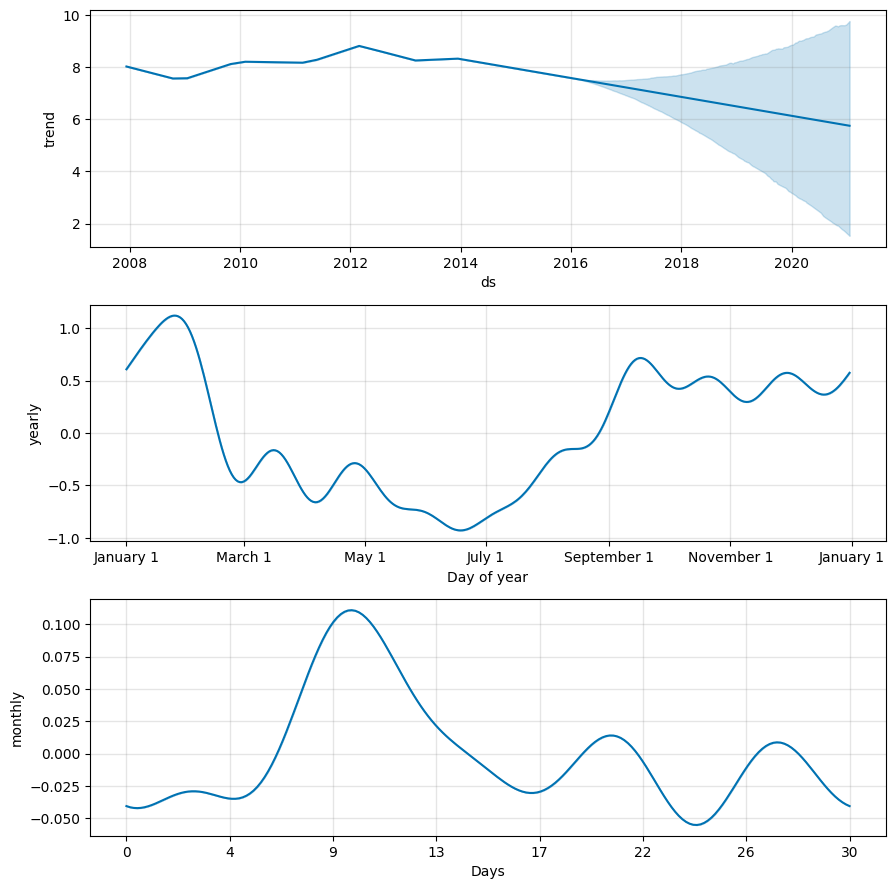

In [12]:
m = Prophet(weekly_seasonality=False)
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
forecast = m.fit(man_df).predict(future)
fig = m.plot_components(forecast)

# Acks & Refs

- Prophet -- Getting Started Guide: [https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html#specifying-custom-seasonalities](https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html#specifying-custom-seasonalities)
- Payton Manning Data: https://github.com/facebook/prophet/blob/main/examples/example_wp_log_peyton_manning.csv
- Python `holidays` package: [https://github.com/vacanza/python-holidays/](https://github.com/vacanza/python-holidays/)
- Taylor & Letham Paper -- Facebook -- Inventors of Prophet: [https://peerj.com/preprints/3190/](https://peerj.com/preprints/3190/)
- Wikipedia Article on Fourier Series: [https://en.wikipedia.org/wiki/Fourier_series#](https://en.wikipedia.org/wiki/Fourier_series#)